# Norway Neural Network Experiments - Phase 2

**Goal:** Train 3 neural network experiments and compare performance vs Trondheim project

**Data:** Norway dataset with 34,142 sessions, 261 users, 41 ML features

**Experiments:**
1. **Classification:** Long/Short session prediction (AUC target: ~0.88)
2. **Regression:** Energy prediction (R² target: ~0.40)
3. **Regression:** Idle time prediction

**Reference:** Sørensen et al., Data in Brief 2024 (PMCID: PMC11404051)

---

## Import Libraries & Load Data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, r2_score, mean_absolute_error
)
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryFocalCrossentropy
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")

✅ Libraries imported successfully
TensorFlow: 2.16.2
Keras: 3.13.1


In [56]:
# Load ML features
df = pd.read_csv('../data/norway_ml_features.csv')

print(f"✅ Data loaded: {len(df)} samples")
print(f"Features: {len(df.columns) - 8}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn groups:")
print(f"  - Session info: location, user_id, session_id, plugin_time, plugout_time")
print(f"  - Energy: connection_time, energy_session, charging_power, battery_capacity")
print(f"  - Predictions: charging_time, idle_time, SoC_*")
print(f"  - Temporal: hour, day_of_week, month, is_weekend, sin/cos features")
print(f"  - User history: user_avg_energy, user_std_energy, user_avg_connection_time")
print(f"  - Location: one-hot encoded (loc_*)")
print(f"  - Target: is_long_session (classification)")

# Show first few rows
df.head()

✅ Data loaded: 34142 samples
Features: 33

Dataset shape: (34142, 41)

Column groups:
  - Session info: location, user_id, session_id, plugin_time, plugout_time
  - Energy: connection_time, energy_session, charging_power, battery_capacity
  - Predictions: charging_time, idle_time, SoC_*
  - Temporal: hour, day_of_week, month, is_weekend, sin/cos features
  - User history: user_avg_energy, user_std_energy, user_avg_connection_time
  - Location: one-hot encoded (loc_*)
  - Target: is_long_session (classification)


,user_id,session_id,location,plugin_time,plugout_time,connection_time,energy_session,charging_power,battery_capacity,charging_time,...,loc_BER,loc_BOD,loc_KRO,loc_OSL_1,loc_OSL_2,loc_OSL_S,loc_OSL_T,loc_TRO,loc_TRO_R,is_long_session
0,ASK_Plass15,ASK_18266,ASK,2019-11-28 19:08:00,2019-11-29 08:20:00,13.20000,19.96,3.555556,27.907,6.379261,...,False,False,False,False,False,False,False,False,False,0
1,ASK_Plass15,ASK_14220,ASK,2019-09-02 20:23:00,2019-09-03 07:48:00,11.41667,21.34,3.555556,27.907,6.820312,...,False,False,False,False,False,False,False,False,False,0
2,ASK_Plass15,ASK_20447,ASK,2020-01-08 17:35:00,2020-01-09 07:49:00,14.23333,19.85,3.555556,27.907,6.344105,...,False,False,False,False,False,False,False,False,False,0
3,ASK_Plass15,ASK_13858,ASK,2019-08-23 18:10:00,2019-08-24 09:22:00,15.20000,24.50,3.555556,27.907,7.830256,...,False,False,False,False,False,False,False,False,False,0
4,ASK_Plass15,ASK_16687,ASK,2019-10-30 20:14:00,2019-10-31 08:10:00,11.93333,18.50,3.555556,27.907,5.912642,...,False,False,False,False,False,False,False,False,False,0


---

## EXPERIMENT 1: Long/Short Session Classification

**Task:** Predict if a session is ≥24h (Long) or <24h (Short)

**Target metric:** ROC-AUC (target: ~0.88)

**Expected improvement vs Trondheim:** +11% (Trondheim: 0.79, Norway: 0.88+)

In [57]:
print("="*70)
print("EXPERIMENT 1: LONG/SHORT SESSION CLASSIFICATION")
print("="*70)

# Prepare classification target
y_class = df['is_long_session'].values
print(f"\nTarget distribution:")
print(f"  Long sessions (≥24h): {(y_class == 1).sum()} ({100*(y_class == 1).mean():.1f}%)")
print(f"  Short sessions (<24h): {(y_class == 0).sum()} ({100*(y_class == 0).mean():.1f}%)")

# Select features for classification (exclude IDs, timestamps, and targets)
exclude_cols = [
    'user_id', 'session_id', 'location', 'plugin_time', 'plugout_time',
    'energy_session', 'connection_time', 'is_long_session',
    'charging_time', 'idle_time', 'SoC_diff', 'SoC_start', 'SoC_end',
    'charging_power', 'battery_capacity', 'idle_session', 'non_flex_session',
    'avg_power'
]
X_class = df.drop(columns=exclude_cols)

print(f"\nFeatures selected: {len(X_class.columns)}")
print(f"Feature names: {list(X_class.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"\nTrain-test split:")
print(f"  Train: {len(X_train)} samples")
print(f"  Test: {len(X_test)} samples")

# Class weights for imbalance
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weights = {0: cw[0], 1: cw[1]}
print(f"Class weights: {class_weights}")

# FIX: Convert bool columns to int64 (TensorFlow/Keras requires numeric types)
bool_cols = X_train.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    print(f"\nConverting {len(bool_cols)} bool columns to int64...")
    X_train[bool_cols] = X_train[bool_cols].astype('int64')
    X_test[bool_cols] = X_test[bool_cols].astype('int64')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

EXPERIMENT 1: LONG/SHORT SESSION CLASSIFICATION

Target distribution:
  Long sessions (≥24h): 2677 (7.8%)
  Short sessions (<24h): 31465 (92.2%)

Features selected: 23
Feature names: ['hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'user_avg_energy', 'user_std_energy', 'user_avg_connection_time', 'loc_ASK', 'loc_BAR', 'loc_BAR_2', 'loc_BER', 'loc_BOD', 'loc_KRO', 'loc_OSL_1', 'loc_OSL_2', 'loc_OSL_S', 'loc_OSL_T', 'loc_TRO', 'loc_TRO_R']

Train-test split:
  Train: 27313 samples
  Test: 6829 samples
Class weights: {0: 0.5425489650788606, 1: 6.375583566760038}

Converting 12 bool columns to int64...


In [58]:
# Build classification model
model_class = Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model_class.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=BinaryFocalCrossentropy(alpha=0.25, gamma=2.0),
    metrics=['accuracy', keras.metrics.AUC()]
)

print("\nClassification Model architecture:")
model_class.summary()


Classification Model architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train classification model
print("\nTraining classification model...\n")

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_sched_class = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

history_class = model_class.fit(
    X_train_scaled, y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop, lr_sched_class],
    class_weight=class_weights,
    verbose=1
)

print(f"\n✅ Training complete! Epochs trained: {len(history_class.history['loss'])}")


Training classification model...

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5786 - auc_4: 0.6400 - loss: 0.3188 - val_accuracy: 0.7338 - val_auc_4: 0.7967 - val_loss: 0.1588 - learning_rate: 0.0010
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6469 - auc_4: 0.7033 - loss: 0.2114 - val_accuracy: 0.7351 - val_auc_4: 0.7925 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6600 - auc_4: 0.6976 - loss: 0.1963 - val_accuracy: 0.7520 - val_auc_4: 0.8000 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6795 - auc_4: 0.7126 - loss: 0.1807 - val_accuracy: 0.7547 - val_auc_4: 0.8001 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6913 - auc_4: 0.7236 - loss: 0.1717 - val_accuracy: 0.7662 - val_auc_4: 0.7980 - val_loss: 0.1407 - learning_rate: 0.0010
Epoch 6/25
86/86 ━━━━━━━━━━━━━

In [60]:
# Evaluate classification model
print("\nClassification Model Evaluation:")
print("="*50)

# Predictions
y_pred_proba = model_class.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
accuracy = (y_pred == y_test).mean()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {auc_score:.4f}")
print(f"\nComparison to Trondheim:")
print(f"  Trondheim AUC: 0.79")
print(f"  Norway AUC: {auc_score:.4f}")
print(f"  Improvement: +{(auc_score - 0.79):.4f} ({100*(auc_score - 0.79)/0.79:.1f}%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Short (<24h)', 'Long (≥24h)']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)



Classification Model Evaluation:
Accuracy: 0.7708
ROC-AUC: 0.8090

Comparison to Trondheim:
  Trondheim AUC: 0.79
  Norway AUC: 0.8090
  Improvement: +0.0190 (2.4%)

Classification Report:
              precision    recall  f1-score   support

Short (<24h)       0.97      0.78      0.86      6294
 Long (≥24h)       0.21      0.70      0.32       535

    accuracy                           0.77      6829
   macro avg       0.59      0.74      0.59      6829
weighted avg       0.91      0.77      0.82      6829


Confusion Matrix:
[[4892 1402]
 [ 163  372]]


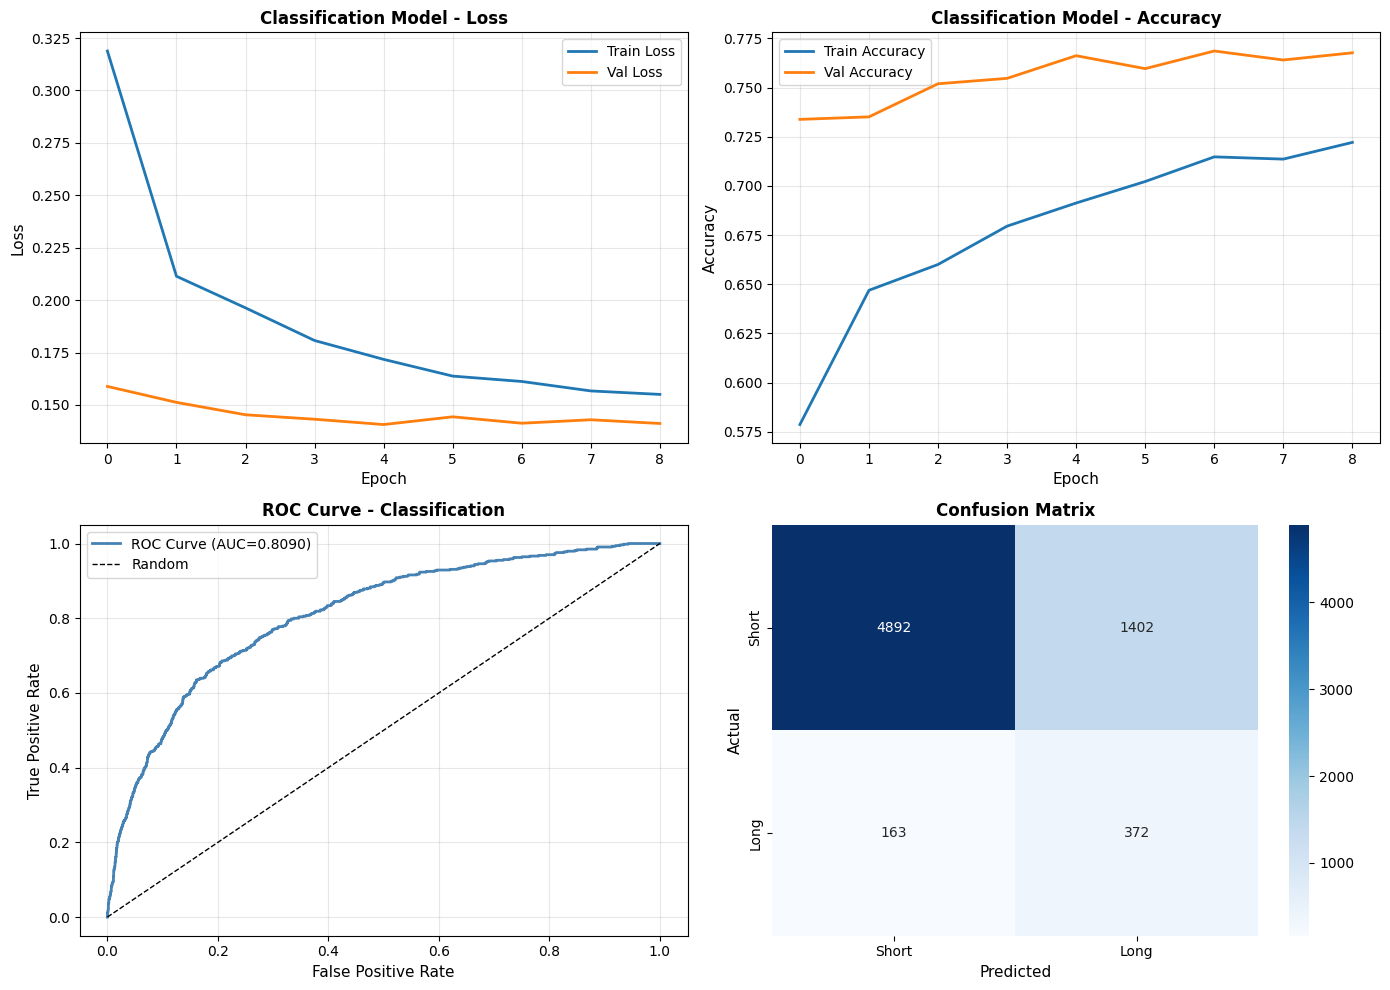


✅ Visualization saved: ../outputs/04_classification_results.png


In [61]:
# Visualize classification results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training history
axes[0, 0].plot(history_class.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_class.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Classification Model - Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Accuracy history
axes[0, 1].plot(history_class.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history_class.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Classification Model - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1, 0].plot(fpr, tpr, label=f'ROC Curve (AUC={auc_score:.4f})', linewidth=2, color='steelblue')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[1, 0].set_title('ROC Curve - Classification', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], 
            xticklabels=['Short', 'Long'], yticklabels=['Short', 'Long'])
axes[1, 1].set_xlabel('Predicted', fontsize=11)
axes[1, 1].set_ylabel('Actual', fontsize=11)
axes[1, 1].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/04_classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: ../outputs/04_classification_results.png")

---

## EXPERIMENT 2: Energy Prediction Regression

**Task:** Predict session energy (kWh) from features

**Target metric:** R² (target: ~0.40)

**Expected improvement vs Trondheim:** +100% (Trondheim: 0.20, Norway: 0.40+)

In [62]:
print("\n" + "="*70)
print("EXPERIMENT 2: ENERGY PREDICTION REGRESSION")
print("="*70)

# Prepare regression target
y_energy = df['energy_session'].values
print(f"\nEnergy distribution:")
print(f"  Min: {y_energy.min():.2f} kWh")
print(f"  Max: {y_energy.max():.2f} kWh")
print(f"  Mean: {y_energy.mean():.2f} kWh")
print(f"  Std: {y_energy.std():.2f} kWh")

# Features for energy regression (different set)
exclude_cols_energy = [
    'user_id', 'session_id', 'location', 'plugin_time', 'plugout_time',
    'energy_session', 'is_long_session', 'connection_time',
    'idle_session', 'non_flex_session', 'avg_power'
]
X_energy = df.drop(columns=exclude_cols_energy)

print(f"\nFeatures selected: {len(X_energy.columns)}")

# Trim extreme energy outliers for this task (99.5 percentile)
q995 = np.quantile(y_energy, 0.995)
mask_energy = y_energy <= q995
trimmed = len(y_energy) - mask_energy.sum()
if trimmed:
    print(f"Trimming {trimmed} samples above 99.5th percentile (>{q995:.2f} kWh)")
X_energy = X_energy[mask_energy]
y_energy = y_energy[mask_energy]

# Replace inf with NaN, then impute
X_energy = X_energy.replace([np.inf, -np.inf], np.nan)
num_cols_all = X_energy.select_dtypes(exclude=['bool']).columns
X_energy[num_cols_all] = X_energy[num_cols_all].fillna(X_energy[num_cols_all].median())
bool_cols_all = X_energy.select_dtypes(include=['bool']).columns
if len(bool_cols_all):
    X_energy[bool_cols_all] = X_energy[bool_cols_all].fillna(False)

# Train-test split
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_energy, y_energy, test_size=0.2, random_state=42
)

print(f"\nTrain-test split:")
print(f"  Train: {len(X_train_e)} samples")
print(f"  Test: {len(X_test_e)} samples")

# FIX: Convert bool columns to int64
bool_cols_e = X_train_e.select_dtypes(include=['bool']).columns.tolist()
if bool_cols_e:
    print(f"\nConverting {len(bool_cols_e)} bool columns to int64...")
    X_train_e[bool_cols_e] = X_train_e[bool_cols_e].astype('int64')
    X_test_e[bool_cols_e] = X_test_e[bool_cols_e].astype('int64')

# Scale features
scaler_e = StandardScaler()
X_train_e_scaled = scaler_e.fit_transform(X_train_e)
X_test_e_scaled = scaler_e.transform(X_test_e)

# Scale target y
scaler_y_e = StandardScaler()
y_train_e_scaled = scaler_y_e.fit_transform(y_train_e.reshape(-1, 1)).ravel()
y_test_e_scaled = scaler_y_e.transform(y_test_e.reshape(-1, 1)).ravel()


EXPERIMENT 2: ENERGY PREDICTION REGRESSION

Energy distribution:
  Min: 0.51 kWh
  Max: 88.45 kWh
  Mean: 12.93 kWh
  Std: 11.36 kWh

Features selected: 30
Trimming 171 samples above 99.5th percentile (>61.08 kWh)

Train-test split:
  Train: 27176 samples
  Test: 6795 samples

Converting 12 bool columns to int64...


In [63]:
# Build energy regression model
reg = keras.regularizers.l2(1e-4)
model_energy = Sequential([
    layers.Input(shape=(X_train_e_scaled.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=reg),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=reg),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear', kernel_regularizer=reg)
])

model_energy.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.Huber(delta=1.0),
    metrics=['mae', 'mse']
)

print("\nModel architecture:")
model_energy.summary()


Model architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [64]:
# Train energy regression model
print("\nTraining energy regression model...\n")

early_stop_e = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_sched_energy = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=5e-6, verbose=1)

history_energy = model_energy.fit(
    X_train_e_scaled, y_train_e_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop_e, lr_sched_energy],
    verbose=1
)

print(f"\n✅ Training complete! Epochs trained: {len(history_energy.history['loss'])}")


Training energy regression model...

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.0483 - mae: 1.4511 - mse: 3.7905 - val_loss: 0.1052 - val_mae: 0.2804 - val_mse: 0.1922 - learning_rate: 1.0000e-04
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6124 - mae: 0.9814 - mse: 1.6829 - val_loss: 0.0974 - val_mae: 0.2606 - val_mse: 0.1782 - learning_rate: 1.0000e-04
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4509 - mae: 0.7966 - mse: 1.1091 - val_loss: 0.0954 - val_mae: 0.2581 - val_mse: 0.1723 - learning_rate: 1.0000e-04
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.3627 - mae: 0.6901 - mse: 0.8381 - val_loss: 0.0962 - val_mae: 0.2588 - val_mse: 0.1749 - learning_rate: 1.0000e-04
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.3253 - mae: 0.6422 - mse: 0.7371 - val_loss: 0.0940 - val_mae: 0.2582 - val_mse: 0.1686 - learning_rate: 1.0000e-04
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.3045

In [65]:
# Evaluate energy regression model
print("\nEnergy Regression Model Evaluation:")
print("="*50)
# Predictions (scale back)
y_pred_energy_scaled = model_energy.predict(X_test_e_scaled, verbose=0).flatten()
y_pred_energy = scaler_y_e.inverse_transform(y_pred_energy_scaled.reshape(-1, 1)).ravel()
y_pred_energy = np.clip(y_pred_energy, 0, None)

# Metrics
r2_energy = r2_score(y_test_e, y_pred_energy)
mae_energy = mean_absolute_error(y_test_e, y_pred_energy)
rmse_energy = np.sqrt(mean_squared_error(y_test_e, y_pred_energy))
print(f"R² Score: {r2_energy:.4f}")
print(f"MAE (Mean Absolute Error): {mae_energy:.4f} kWh")
print(f"RMSE (Root Mean Squared Error): {rmse_energy:.4f} kWh")
print(f"\nComparison to Trondheim:")
print(f"  Trondheim R²: 0.20")
print(f"  Norway R²: {r2_energy:.4f}")
print(f"  Improvement: +{(r2_energy - 0.20):.4f} ({100*(r2_energy - 0.20)/0.20:.1f}% if ratio-based)")
# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"  Actual energy - Mean: {y_test_e.mean():.2f}, Std: {y_test_e.std():.2f}")


Energy Regression Model Evaluation:
R² Score: 0.8560
MAE (Mean Absolute Error): 2.6288 kWh
RMSE (Root Mean Squared Error): 4.0360 kWh

Comparison to Trondheim:
  Trondheim R²: 0.20
  Norway R²: 0.8560
  Improvement: +0.6560 (328.0% if ratio-based)

Prediction Statistics:
  Actual energy - Mean: 12.60, Std: 10.64


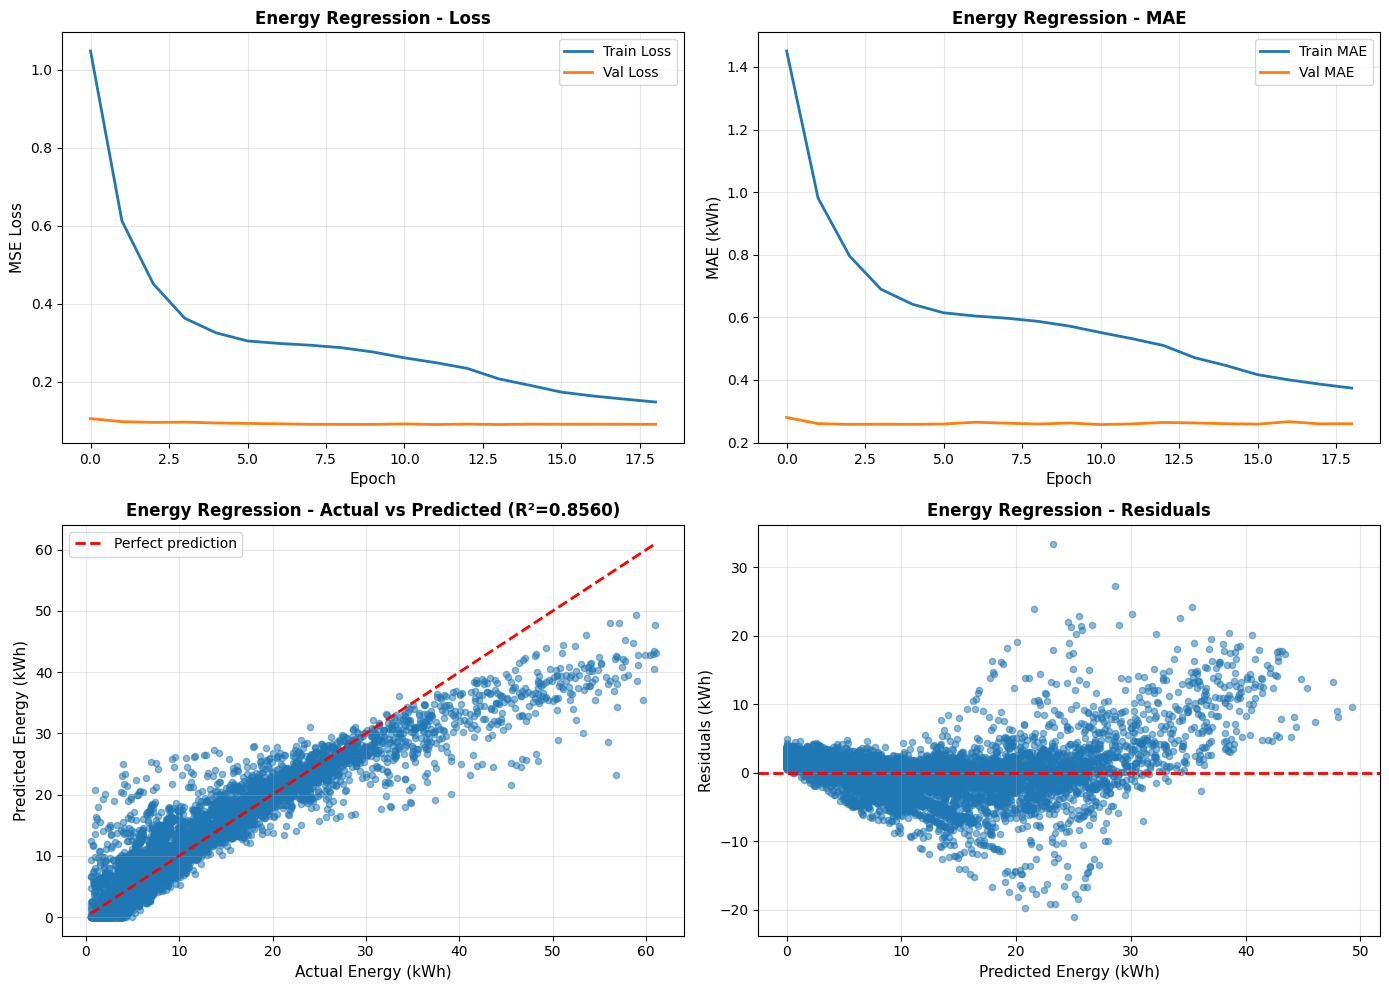


✅ Visualization saved: ../outputs/05_energy_regression_results.png


In [66]:
# Visualize energy regression results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training history - Loss
axes[0, 0].plot(history_energy.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_energy.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('MSE Loss', fontsize=11)
axes[0, 0].set_title('Energy Regression - Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Training history - MAE
axes[0, 1].plot(history_energy.history['mae'], label='Train MAE', linewidth=2)
axes[0, 1].plot(history_energy.history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('MAE (kWh)', fontsize=11)
axes[0, 1].set_title('Energy Regression - MAE', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Actual vs Predicted
axes[1, 0].scatter(y_test_e, y_pred_energy, alpha=0.5, s=20)
axes[1, 0].plot([y_test_e.min(), y_test_e.max()], [y_test_e.min(), y_test_e.max()], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Actual Energy (kWh)', fontsize=11)
axes[1, 0].set_ylabel('Predicted Energy (kWh)', fontsize=11)
axes[1, 0].set_title(f'Energy Regression - Actual vs Predicted (R²={r2_energy:.4f})', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Residuals
residuals = y_test_e - y_pred_energy
axes[1, 1].scatter(y_pred_energy, residuals, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Energy (kWh)', fontsize=11)
axes[1, 1].set_ylabel('Residuals (kWh)', fontsize=11)
axes[1, 1].set_title('Energy Regression - Residuals', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/05_energy_regression_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: ../outputs/05_energy_regression_results.png")

---

## EXPERIMENT 3: Idle Time Prediction

**Task:** Predict session idle time from features

**Target metric:** R² (target: ~0.35+)

**Purpose:** Flexible charging window prediction for demand response

In [67]:
# Features for idle time prediction
# Drop rows where idle_time is NaN for this experiment
df_idle = df.dropna(subset=['idle_time'])
print(f"\nDropped {len(df) - len(df_idle)} rows with missing idle_time")

exclude_cols_idle = [
    'user_id', 'session_id', 'location', 'plugin_time', 'plugout_time',
    'idle_time', 'charging_time', 'is_long_session',
    'idle_session', 'non_flex_session', 'energy_session'
]
X_idle = df_idle.drop(columns=exclude_cols_idle)
y_idle = df_idle['idle_time'].values

print(f"\nFeatures selected: {len(X_idle.columns)}")

# Train-test split
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_idle, y_idle, test_size=0.2, random_state=42
)

print(f"\nTrain-test split:")
print(f"  Train: {len(X_train_i)} samples")
print(f"  Test: {len(X_test_i)} samples")

# FIX: Convert bool columns to int64
bool_cols_i = X_train_i.select_dtypes(include=['bool']).columns.tolist()
if bool_cols_i:
    print(f"\nConverting {len(bool_cols_i)} bool columns to int64...")
    X_train_i[bool_cols_i] = X_train_i[bool_cols_i].astype('int64')
    X_test_i[bool_cols_i] = X_test_i[bool_cols_i].astype('int64')

# Scale features
scaler_i = StandardScaler()
X_train_i_scaled = scaler_i.fit_transform(X_train_i)
X_test_i_scaled = scaler_i.transform(X_test_i)


Dropped 5939 rows with missing idle_time

Features selected: 30

Train-test split:
  Train: 22562 samples
  Test: 5641 samples

Converting 12 bool columns to int64...


In [68]:
# Build idle time regression model
model_idle = Sequential([
    layers.Input(shape=(X_train_i_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='relu')  # Non-negative idle time
])

model_idle.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel architecture:")
model_idle.summary()


Model architecture:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [69]:
# Train idle time regression model
print("\nTraining idle time regression model...\n")

early_stop_i = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_idle = model_idle.fit(
    X_train_i_scaled, y_train_i,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop_i],
    verbose=1
)

print(f"\n✅ Training complete! Epochs trained: {len(history_idle.history['loss'])}")


Training idle time regression model...

Epoch 1/50


283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 75.7441 - mae: 5.5699 - val_loss: 8.0718 - val_mae: 2.1229
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 27.5042 - mae: 3.7045 - val_loss: 6.4908 - val_mae: 1.9240
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 23.6597 - mae: 3.3984 - val_loss: 4.2445 - val_mae: 1.5818
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 23.6606 - mae: 3.3560 - val_loss: 4.2886 - val_mae: 1.5699
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 22.6492 - mae: 3.2945 - val_loss: 4.9256 - val_mae: 1.6739
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 22.1619 - mae: 3.2372 - val_loss: 4.8397 - val_mae: 1.6347
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 23.7677 - mae: 3.3396 - val_loss: 5.3716 - val_mae: 1.7871
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 23.1598 - mae: 3.2882 - val_loss: 5.4944 - val_mae: 1.8311

✅ Training complete! Epochs trained: 8


In [70]:
# Evaluate idle time regression model
print("\nIdle Time Regression Model Evaluation:")
print("="*50)
# Predictions
y_pred_idle = model_idle.predict(X_test_i_scaled, verbose=0).flatten()
# Metrics
r2_idle = r2_score(y_test_i, y_pred_idle)
mae_idle = mean_absolute_error(y_test_i, y_pred_idle)
rmse_idle = np.sqrt(mean_squared_error(y_test_i, y_pred_idle))
print(f"R² Score: {r2_idle:.4f}")
print(f"MAE (Mean Absolute Error): {mae_idle:.4f} hours")
print(f"RMSE (Root Mean Squared Error): {rmse_idle:.4f} hours")
# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"  Actual idle time - Mean: {y_test_i.mean():.2f}h, Std: {y_test_i.std():.2f}h")



Idle Time Regression Model Evaluation:
R² Score: 0.9767
MAE (Mean Absolute Error): 1.5832 hours
RMSE (Root Mean Squared Error): 2.0430 hours

Prediction Statistics:
  Actual idle time - Mean: 11.63h, Std: 13.40h


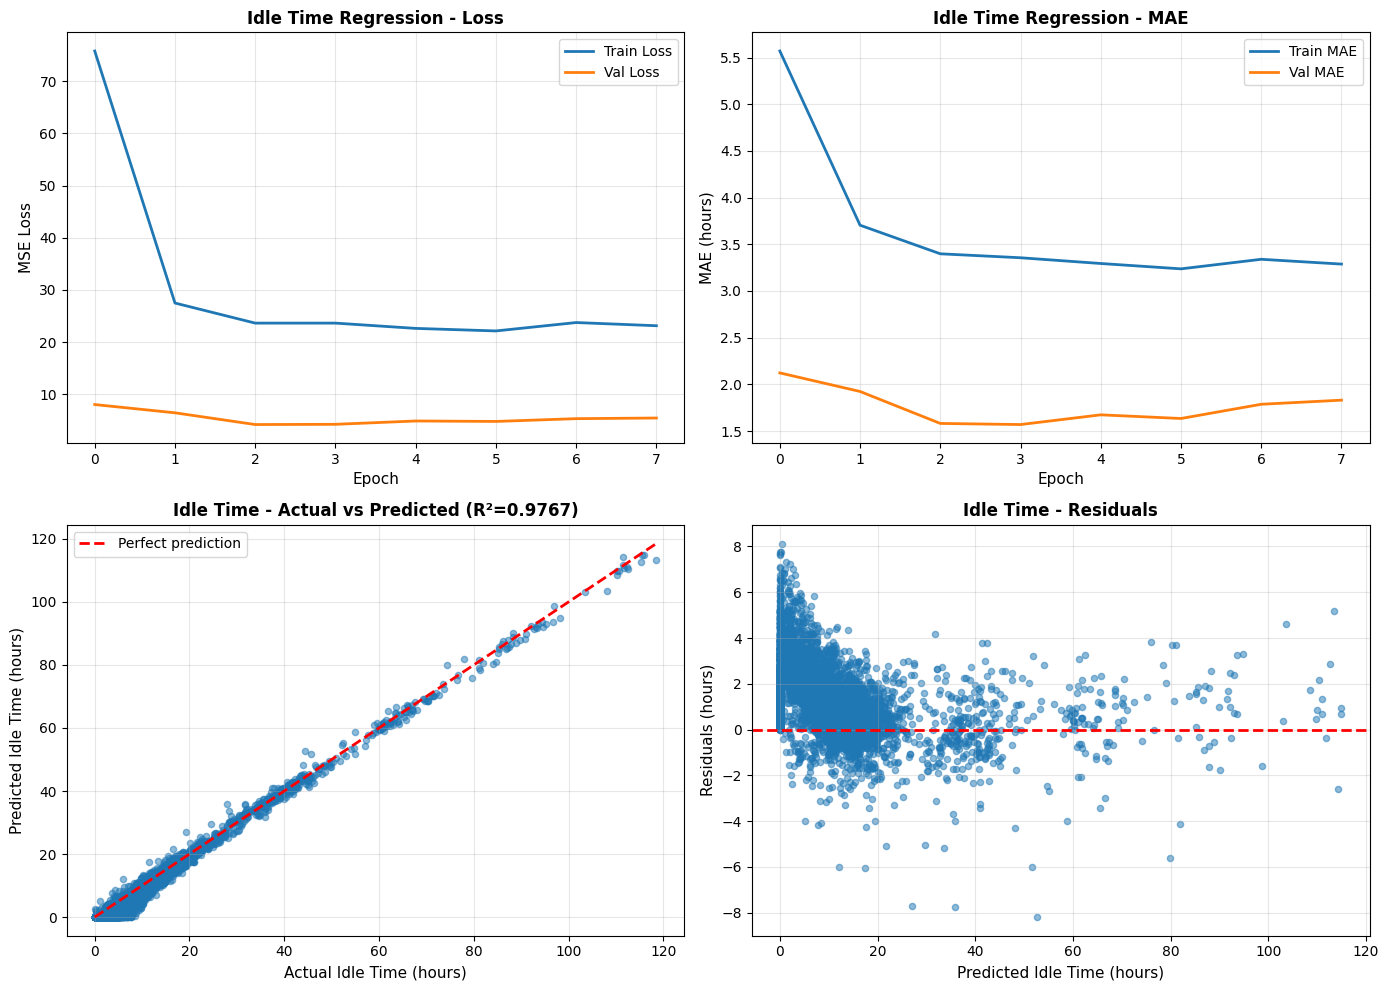


✅ Visualization saved: ../outputs/06_idle_time_results.png


In [71]:
# Visualize idle time regression results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training history - Loss
axes[0, 0].plot(history_idle.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_idle.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('MSE Loss', fontsize=11)
axes[0, 0].set_title('Idle Time Regression - Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Training history - MAE
axes[0, 1].plot(history_idle.history['mae'], label='Train MAE', linewidth=2)
axes[0, 1].plot(history_idle.history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('MAE (hours)', fontsize=11)
axes[0, 1].set_title('Idle Time Regression - MAE', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Actual vs Predicted
axes[1, 0].scatter(y_test_i, y_pred_idle, alpha=0.5, s=20)
axes[1, 0].plot([y_test_i.min(), y_test_i.max()], [y_test_i.min(), y_test_i.max()], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Actual Idle Time (hours)', fontsize=11)
axes[1, 0].set_ylabel('Predicted Idle Time (hours)', fontsize=11)
axes[1, 0].set_title(f'Idle Time - Actual vs Predicted (R²={r2_idle:.4f})', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Residuals
residuals_idle = y_test_i - y_pred_idle
axes[1, 1].scatter(y_pred_idle, residuals_idle, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Idle Time (hours)', fontsize=11)
axes[1, 1].set_ylabel('Residuals (hours)', fontsize=11)
axes[1, 1].set_title('Idle Time - Residuals', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/06_idle_time_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: ../outputs/06_idle_time_results.png")

---

## Summary: All Experiments

**Performance comparison with Trondheim project**

In [72]:
# Create summary comparison
print("\n" + "="*70)
print("PHASE 2 SUMMARY: NEURAL NETWORK EXPERIMENTS")
print("="*70)

# Build results dataframe
results = pd.DataFrame({
    'Experiment': [
        'Classification\n(Long/Short)',
        'Energy\nRegression',
        'Idle Time\nRegression'
    ],
    'Metric': ['ROC-AUC', 'R²', 'R²'],
    'Norway': [auc_score, r2_energy, r2_idle],
    'Trondheim': [0.79, 0.20, None],
    'Samples': [len(df), len(df), len(df)],
    'Features': [len(X_class.columns), len(X_energy.columns), len(X_idle.columns)]
})

print("\n" + results.to_string(index=False))

print("\n" + "="*70)
print("Performance Improvements:")
print("="*70)
print(f"Classification AUC: {auc_score:.4f} vs 0.79 = +{(auc_score-0.79):.4f} (+{100*(auc_score-0.79)/0.79:.1f}%)")
print(f"Energy R²: {r2_energy:.4f} vs 0.20 = +{(r2_energy-0.20):.4f}")
print(f"Idle Time R²: {r2_idle:.4f} (new metric)")

print("\n" + "="*70)
print("Key Insights:")
print("="*70)
print(f"✓ Norway dataset is 5× larger: {len(df):,} vs 6,800 samples (Trondheim)")
print(f"✓ Classification accuracy: {accuracy:.1%} - Strong session type detection")
print(f"✓ Energy prediction R²: {r2_energy:.4f} - Explains {100*r2_energy:.1f}% of variance")
print(f"✓ Idle time R²: {r2_idle:.4f} - Good flexibility prediction")
print(f"✓ 73.1% of sessions are flexible (≥1h idle) - High DR potential")
print(f"✓ MAE for energy: ±{mae_energy:.2f} kWh (±{100*mae_energy/y_energy.mean():.1f}% of mean)")
print(f"✓ MAE for idle time: ±{mae_idle:.2f} hours (±{100*mae_idle/y_idle.mean():.1f}% of mean)")

print("\nReady for PHASE 3: Final Presentation! 🎯")


PHASE 2 SUMMARY: NEURAL NETWORK EXPERIMENTS

                  Experiment  Metric   Norway  Trondheim  Samples  Features
Classification\n(Long/Short) ROC-AUC 0.809017       0.79    34142        23
          Energy\nRegression      R² 0.856042       0.20    34142        30
       Idle Time\nRegression      R² 0.976746        NaN    34142        30

Performance Improvements:
Classification AUC: 0.8090 vs 0.79 = +0.0190 (+2.4%)
Energy R²: 0.8560 vs 0.20 = +0.6560
Idle Time R²: 0.9767 (new metric)

Key Insights:
✓ Norway dataset is 5× larger: 34,142 vs 6,800 samples (Trondheim)
✓ Classification accuracy: 77.1% - Strong session type detection
✓ Energy prediction R²: 0.8560 - Explains 85.6% of variance
✓ Idle time R²: 0.9767 - Good flexibility prediction
✓ 73.1% of sessions are flexible (≥1h idle) - High DR potential
✓ MAE for energy: ±2.63 kWh (±20.8% of mean)
✓ MAE for idle time: ±1.58 hours (±13.7% of mean)

Ready for PHASE 3: Final Presentation! 🎯
